In [1]:
%reset -f

In [2]:
import torch
import os
from pyDOE import lhs
from utils import torchIWT
from torch.autograd import Variable
import numpy as np
import scipy.io as sio
import torch.nn as nn
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
seed = 2947
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [4]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)
    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [5]:
class Model:
    def __init__(self, net, epoch,
                 lb, ub,
                 x_bc, u_bc,
                 x, t,
                 x_f_loss_fun,
                 x_test_point, x_test_exact):
        self.net = net
        self.epoch = epoch
        self.lb = lb
        self.ub = ub

        self.x_bc = x_bc
        self.u_bc = u_bc

        self.x = x
        self.t = t

        self.x_f = None

        self.x_f_loss_fun = x_f_loss_fun
        self.x_test_point = x_test_point
        self.x_test_exact = x_test_exact

        self.sample_N = 2000
        self.sample_M = 1000

        self.x_f_N = None
        self.x_f_M = None

        self.x_bc_s = torch.tensor(0.).float().to(device)
        self.x_f_s = torch.tensor(0.).float().to(device)
        self.x_test_estimate_collect = []

        self.top1 = torch.inf

    def true_loss(self, loss_e, loss_bc):
        loss = torch.exp(-self.x_f_s.detach()) * loss_e \
                + torch.exp(-self.x_bc_s.detach()) * loss_bc
        return loss
    
    def likelihood_loss(self, loss_e, loss_bc):
        loss = torch.exp(-self.x_f_s) * loss_e.detach() + self.x_f_s \
                + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s
        return loss
    
    def evaluate(self):
        pred = self.net(self.x_test_point).cpu().detach().numpy()
        u_pred, v_pred, p_pred = pred[:, [0]], pred[:, [1]], pred[:, [2]]
        pred = np.sqrt(u_pred ** 2 + v_pred ** 2)
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error
    
    def random_sample(self, num):
        temp = torch.from_numpy(self.lb + (self.ub - self.lb) * lhs(2, num)).float().to(device)
        return temp

    def run(self, lr, wlr, j0, J_tmp, e_tmp):

        optim = torch.optim.Adam(self.net.parameters(), lr)
        optim_weight = torch.optim.Adam([self.x_f_s] + [self.x_bc_s], lr=wlr)
        optim2 = torch.optim.LBFGS(self.net.parameters(), lr=1.0,
            max_iter=50000, max_eval=50000, history_size=50,
            tolerance_grad=1e-7, tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

        for i in range(self.epoch):
            f_u, f_v, f_f = self.x_f_loss_fun(self.x_f, self.net)
            loss_e = torch.mean(f_u ** 2) + torch.mean(f_v ** 2) + torch.mean(f_f ** 2)
            
            u_bc_pred = self.net(self.x_bc)
            u, v, p = u_bc_pred[:, [0]], u_bc_pred[:, [1]], u_bc_pred[:, [2]]
            loss_bc = torch.mean((torch.cat((u, v), dim=-1) - self.u_bc) ** 2)

            optim.zero_grad()
            loss = self.true_loss(loss_e, loss_bc)
            if ((i+1) % 2500) == 0 and (i != 0):
                self.move_point(j0, J_tmp, e_tmp)
            print('network train epoch: {}, loss: {}'.format(i, loss.item()), end='\r')

            loss.backward()
            optim.step()            
            optim_weight.zero_grad()
            loss = self.likelihood_loss(loss_e, loss_bc)
            loss.backward()
            optim_weight.step()
        print("\nOPTIM1 DONE")


        closure_i = 0
        def closure():
            optim2.zero_grad()

            f_u, f_v, f_f = self.x_f_loss_fun(self.x_f, self.net)
            loss_e = torch.mean(f_u ** 2) + torch.mean(f_v ** 2) + torch.mean(f_f ** 2)
            
            u_bc_pred = self.net(self.x_bc)
            u, v, p = u_bc_pred[:, [0]], u_bc_pred[:, [1]], u_bc_pred[:, [2]]
            loss_bc = torch.mean((torch.cat((u, v), dim=-1) - self.u_bc) ** 2)

            loss = self.true_loss(loss_e, loss_bc)
            loss.backward()
            nonlocal closure_i
            closure_i += 1
            # if closure_i % 2500 == 0:
            #     self.move_point(j0, J_tmp, e_tmp)
            print('network train epoch: {}, OPTIM2 LOSS:{}'.format(closure_i, loss.item()), end='\r')
            return loss
        
        optim2.step(closure)
        print("\nOPTIM2 DONE")
        error = self.evaluate()
        if error < self.top1:
            self.top1 = error
            torch.save(self.net.state_dict(), './best_model.pth')
        print('Test_L2error:', '{0:.2e}'.format(error))
        self.x_test_estimate_collect.append([error])
            
    def train(self, move_epoch, lr, wlr, j0, J, e):
        self.x_f_N = self.random_sample(self.sample_N)
        self.x_f_M = self.random_sample(self.sample_M)

        self.x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        
        self.x_f_s = torch.tensor(0.).float().to(device)
        self.x_bc_s = torch.tensor(0.).float().to(device)

        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)
        
        self.run(lr[0], wlr, j0, J, e)

        for j in range(1, move_epoch):
            print("epoch: ", j)
            if j > 4:
                lr_tmp = lr[-1]
            else:
                lr_tmp = lr[j]
            self.run(lr_tmp, wlr, j0, J, e) 
    
    def move_point(self, j0, J_tmp, e_tmp):
        out = self.net(self.x_test_point)
        imgl_u, imgl_v, imgl_p = out[:, [0]], out[:, [1]], out[:, [2]]
        imgl_fltn = torch.sqrt(imgl_u ** 2 + imgl_v ** 2)
        imgl = imgl_fltn.reshape(self.x.shape[0], self.t.shape[0])

        iwt = torchIWT(j0, J_tmp, e_tmp).to(device)

        _, idxs = iwt.get_Iwt2d(imgl, self.x, self.t)
        idxn = []
        for i in idxs:
            idxn = idxn + i
        idxn = torch.tensor(idxn).to(device).float()

        kde = gaussian_kde(idxn.cpu().T)
        expanded_idxns = kde.resample(self.sample_M).T
        expanded_idxns = torch.tensor(expanded_idxns).float().to(device)
        k = torch.cat((idxn, expanded_idxns), dim=0)
        # k = expanded_idxns

        k[:,0] = 2 * k[:, 0] / self.x.shape[0] - 1. # x
        k[:,1] = 2 * k[:, 1] / self.t.shape[0] - 1.  # t

        k2 = k[(k[:, 0] >= self.lb[1]) & (k[:, 0] <= self.ub[1]) & (k[:, 1] >= self.lb[0]) & (k[:, 1] < self.ub[0])]
        k = torch.unique(k2, dim=0)

        self.x_f_M = torch.zeros_like(k)
        self.x_f_M[:, 0] = k[:, 1]
        self.x_f_M[:, 1] = k[:, 0]

        self.x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        
        print("\nnumber of moved point:{}".format(self.x_f_M.shape[0]))

In [6]:
def x_f_loss_fun(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    out = train_U(x)
    u, v, p = out[:, [0]], out[:, [1]], out[:, [2]]
    ud = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)
    udx = ud[0][:, [0]]
    udy = ud[0][:, [1]]
    udxx = torch.autograd.grad(udx, x, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, [0]]
    udyy = torch.autograd.grad(udy, x, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, [1]]

    vd = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)
    vdx = vd[0][:, [0]]
    vdy = vd[0][:, [1]]
    vdxx = torch.autograd.grad(vdx, x, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, [0]]
    vdyy = torch.autograd.grad(vdy, x, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, [1]]

    pd = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)
    pdx = pd[0][:, [0]]
    pdy = pd[0][:, [1]]

    f_u = u * udx + v * udy + pdx - (udxx + udyy) / 100.
    f_v = u * vdx + v * vdy + pdy - (vdxx + vdyy) / 100.
    f_f = udx + vdy

    return f_u, f_v, f_f

In [7]:
def get_liddriven_data(ld_file):
    x = np.expand_dims(np.linspace(0, 1, 100), axis=1)
    t = np.expand_dims(np.linspace(0, 1, 100), axis=1)
    X, Y = np.meshgrid(x, t)

    u_ref = np.genfromtxt(ld_file[0], delimiter=',')
    v_ref = np.genfromtxt(ld_file[1], delimiter=',')
    usol = np.sqrt(u_ref ** 2 + v_ref ** 2)

    x_test_np = np.concatenate((np.hstack(X.T).reshape(-1, 1), 
                                np.hstack(Y.T).reshape(-1, 1)), 
                                axis=1)
    
    x = torch.from_numpy(x).float().to(device)
    t = torch.from_numpy(t).float().to(device)
    x_test = torch.from_numpy(x_test_np).float().to(device)
    x_test_exact = torch.from_numpy(usol).float().reshape(-1, 1).to(device)
    return x, t, x_test, x_test_exact

In [8]:
def get_pinn_input_data(Nbc):
    x1_boundary_left = torch.cat((torch.zeros([Nbc, 1]), torch.rand([Nbc, 1])), dim=1)
    x1_boundary_right = torch.cat((torch.ones([Nbc, 1]), torch.rand([Nbc, 1])), dim=1)
    x2_boundary_left = torch.cat((torch.rand([Nbc, 1]), torch.zeros([Nbc, 1])), dim=1)
    x2_boundary_right = torch.cat((torch.rand([Nbc, 1]), torch.ones([Nbc, 1])), dim=1)

    x1_boundary_left_label = torch.cat((torch.zeros([Nbc, 1]), torch.zeros([Nbc, 1])), dim=1)
    x1_boundary_right_label = torch.cat((torch.zeros([Nbc, 1]), torch.zeros([Nbc, 1])), dim=1)
    x2_boundary_left_label = torch.cat((torch.zeros([Nbc, 1]), torch.zeros([Nbc, 1])), dim=1)
    x2_boundary_right_label = torch.cat((torch.ones([Nbc, 1]), torch.zeros([Nbc, 1])), dim=1)

    x_bc = torch.cat((x1_boundary_left, x1_boundary_right, x2_boundary_left, x2_boundary_right), dim=0).to(device)
    u_bc = torch.cat((x1_boundary_left_label, x1_boundary_right_label, x2_boundary_left_label, x2_boundary_right_label), dim=0).to(device)
    return x_bc, u_bc

In [9]:
lb = np.array([0.0, 0.0])
ub = np.array([1.0, 1.0])

layers = [2, 20, 20, 20, 20, 20, 3]
epoch = 5000

net = Net(layers).to(device)

Nbc = 100
x_bc, u_bc = get_pinn_input_data(Nbc)

ld_path = ['./u.csv', './v.csv']
x, t, x_test_point, x_test_exact = get_liddriven_data(ld_path)

model = Model(net, epoch,
                lb, ub,
                x_bc, u_bc,
                x, t,
                x_f_loss_fun,
                x_test_point, x_test_exact)

lr = [0.001, 0.001, 0.0003, 0.0001, 0.00003]
wlr = 0.001



j0 = 0
J = 5
e = 0.003

model.train(move_epoch=10, lr=lr, wlr=wlr, j0=j0, J=J, e=e)  # 10

network train epoch: 2498, loss: 0.124955408275127415
number of moved point:257
network train epoch: 4998, loss: 0.80662447214126594
number of moved point:244
network train epoch: 4999, loss: 0.8038774728775024
OPTIM1 DONE
network train epoch: 21633, OPTIM2 LOSS:0.009343391284346589
OPTIM2 DONE
Test_L2error: 9.23e-02
epoch:  1
network train epoch: 2498, loss: 1.541157484054565474
number of moved point:332
network train epoch: 4998, loss: 0.86571002006530767
number of moved point:320
network train epoch: 4999, loss: 0.635840654373169
OPTIM1 DONE
network train epoch: 2106, OPTIM2 LOSS:0.17357757687568665
OPTIM2 DONE
Test_L2error: 8.18e-02
epoch:  2
network train epoch: 2498, loss: 0.62222319841384893
number of moved point:333
network train epoch: 4998, loss: 1.1895540952682495
number of moved point:358
network train epoch: 4999, loss: 1.1850862503051758
OPTIM1 DONE
network train epoch: 2455, OPTIM2 LOSS:0.8848088979721069
OPTIM2 DONE
Test_L2error: 7.71e-02
epoch:  3
network train epoch: 

In [12]:
out = model.net(x_test_point)

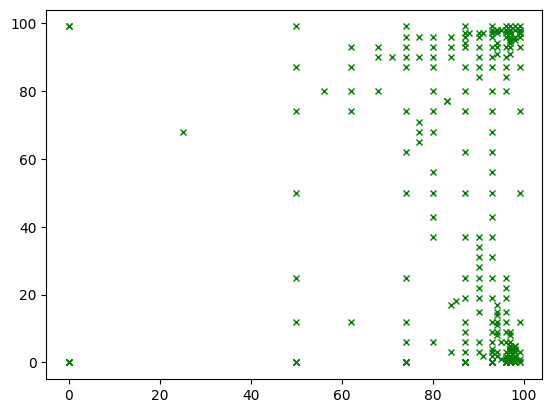

In [13]:
imgl_u, imgl_v, imgl_p = out[:, [0]], out[:, [1]], out[:, [2]]
imgl_fltn = torch.sqrt(imgl_u ** 2 + imgl_v ** 2)
imgl = imgl_fltn.reshape([100, 100])

iwt = torchIWT(j0, 7, 0.03).to(device)

_, idxs = iwt.get_Iwt2d(imgl, model.x, model.t)
idxn = []
for i in idxs:
    idxn = idxn + i
idxn = torch.tensor(idxn).to(device).float()
plt.plot(idxn[:, [1]].cpu().numpy(), idxn[:, [0]].cpu().numpy(), 'gx', markersize=4)